In [4]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics

#visualization
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [42]:
data1 = pd.read_csv("MVC.csv")
print(data.columns)

Index(['BOROUGH', 'NUMTIME', 'LONGITUDE', 'LATITUDE',
       'CONTRIBUTING FACTOR VEHICLE 1', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'PERSONS_AFFECTED',
       'PEDESTRIANS_AFFECTED', 'BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS',
       'STATEN ISLAND', 'PERSONS_TF', 'Environmental', 'Human', 'Unspecified',
       'Vehicular'],
      dtype='object')


In [6]:
data = data[['BOROUGH','NUMTIME','LONGITUDE','LATITUDE','CONTRIBUTING FACTOR VEHICLE 1','NUMBER OF PERSONS KILLED','NUMBER OF PERSONS INJURED','NUMBER OF PEDESTRIANS KILLED','NUMBER OF PEDESTRIANS INJURED']]
data['PERSONS_AFFECTED'] = data['NUMBER OF PERSONS KILLED'] + data['NUMBER OF PERSONS INJURED']
data['PEDESTRIANS_AFFECTED'] = data['NUMBER OF PEDESTRIANS KILLED'] + data['NUMBER OF PEDESTRIANS INJURED']

In [7]:
borough_dummy = data.BOROUGH.str.get_dummies()
data = pd.concat([data,borough_dummy],axis=1)

data = data.dropna()
data = data[data.LONGITUDE !=0]

data['PERSONS_TF']=0
data.loc[data['PERSONS_AFFECTED'] > 0, 'PERSONS_TF']= 1
data.loc[data['PERSONS_AFFECTED'] == 0, 'PERSONS_TF']= 0

In [8]:
value_counts = data["CONTRIBUTING FACTOR VEHICLE 1"].value_counts(ascending=True)
remove = value_counts[value_counts <= 20].index
data = data[~data['CONTRIBUTING FACTOR VEHICLE 1'].isin(remove)]

data['CONTRIBUTING FACTOR VEHICLE 1'] = data['CONTRIBUTING FACTOR VEHICLE 1'].replace(['Driver Inattention/Distraction','Following Too Closely','Failure to Yield Right-of-Way','Backing Unsafely','Passing Too Closely','Unsafe Lane Changing','Passing or Lane Usage Improper','Turning Improperly','Traffic Control Disregarded','Driver Inexperience','Reaction to Uninvolved Vehicle','Unsafe Speed','Fatigued/Drowsy','Alcohol Involvement','Lost Consciousness','Aggressive Driving/Road Rage','Fell Asleep','Illnes','Drugs (illegal)','Drugs (Illegal)','Texting','Outside Car Distraction','Passenger Distraction','Prescription Medication','Failure to Keep Right','Illness','Other Electronic Device','Cell Phone (hand-Held)','Cell Phone (hands-free)','Eating or Drinking','Pedestrian/Bicyclist/Other Pedestrian Error/Confusion','Physical Disability','Reaction to Other Uninvolved Vehicle','Using On Board Navigation Device','Tinted Windows','Vehicle Vandalism','Cell Phone (hand-held)'],'Human')
data['CONTRIBUTING FACTOR VEHICLE 1'] = data['CONTRIBUTING FACTOR VEHICLE 1'].replace(['Other Vehicular','Oversized Vehicle','Brakes Defective','Steering Failure','Tire Failure/Inadequate','Driverless/Runaway Vehicle','Accelerator Defective','Other Lighting Defects','Tow Hitch Defective','Headlights Defective','Windshield Inadequate'],'Vehicular')
data['CONTRIBUTING FACTOR VEHICLE 1'] = data['CONTRIBUTING FACTOR VEHICLE 1'].replace(['Pavement Slippery','View Obstructed/Limited','Glare','Obstruction/Debris','Pavement Defective','Animals Action','Lane Marking Improper/Inadequate','Traffic Control Device Improper/Non-Working','Shoulders Defective/Improper'],'Environmental')
data['CONTRIBUTING FACTOR VEHICLE 1'] = data['CONTRIBUTING FACTOR VEHICLE 1'].replace(['80'],'Unspecified')

In [9]:
factor_dummy = data['CONTRIBUTING FACTOR VEHICLE 1'].str.get_dummies()
data = pd.concat([data,factor_dummy],axis=1)

In [10]:
pred = list(zip(data['NUMTIME'],data['MANHATTAN'],data['QUEENS'],data['BRONX'],data['STATEN ISLAND'],data['BROOKLYN'],data['Human'],data['Environmental'],data['Vehicular'],data['Unspecified']))
resp = data['PERSONS_TF']
sm = SMOTE(random_state=42)
x_res,y_res = sm.fit_resample(pred,resp)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 529959, 1: 529959})


In [13]:
X_feat = pred
y = resp
X_feat_train,X_feat_test, y_feat_train,y_feat_test = train_test_split(X_feat,y,test_size=0.2)

dtc = RandomForestClassifier()
grid={'max_depth':[1,2,3,4,5,10,20,30],
        'criterion':['gini','entropy'],
        'min_samples_leaf':[10,20,30,50,60]}

gs = GridSearchCV(dtc,grid,cv=3,verbose=True,return_train_score=False,n_jobs=-1)
gs.fit(X_feat,y)

scores = pd.DataFrame(gs.cv_results_).filter(regex='param_+|mean_test_score'
                                            ).sort_values('mean_test_score',
                                                          ascending=False).reset_index().drop(['index'],axis=1)
scores.head(10)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  5.5min
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 36.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 50.3min finished


,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_score
0,gini,1,10,0.809755
1,entropy,4,20,0.809755
2,entropy,3,60,0.809755
3,entropy,3,50,0.809755
4,entropy,3,30,0.809755
5,entropy,3,20,0.809755
6,entropy,3,10,0.809755
7,entropy,2,60,0.809755
8,entropy,2,50,0.809755
9,entropy,2,30,0.809755


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)


t = RandomForestClassifier(criterion='entropy',max_depth=4,min_samples_leaf=20)

t.fit(X_train,y_train)
y_test_pred = t.predict(X_test)


print("Classification Report:\n", metrics.classification_report(y_test,y_test_pred))
print("Null accuracy on the test set: ",y_test.mean())
print("Sensitivity/Recall (TPR): ",metrics.recall_score(y_test,y_test_pred,average='micro'))
print("Precision (PPV): ", metrics.precision_score(y_test,y_test_pred,average='micro'))
cm = metrics.confusion_matrix(y_test, y_test_pred)
cm

Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.89    105961
           1       0.00      0.00      0.00     24933

    accuracy                           0.81    130894
   macro avg       0.40      0.50      0.45    130894
weighted avg       0.66      0.81      0.72    130894

Null accuracy on the test set:  0.19048237505156845
Sensitivity/Recall (TPR):  0.8095176249484316
Precision (PPV):  0.8095176249484316


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[105961,      0],
       [ 24933,      0]])

In [21]:
X_feat = pred

y = resp

X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)

depths = [1,2,3,4,5,10,15,20,25,30]
accs = []
for i in depths:
    dtc = RandomForestClassifier(max_depth=i,criterion='entropy',min_samples_leaf=20)
    dtc.fit(X_train,y_train)
    accs.append(dtc.score(X_test,y_test))
    
print('Scores:\n',pd.DataFrame({'Accuracy':accs},index=depths))

Scores:
     Accuracy
1   0.809304
2   0.809304
3   0.809304
4   0.809304
5   0.809304
10  0.809304
15  0.809296
20  0.809288
25  0.809296
30  0.809296


In [18]:
X_feat = data[['LATITUDE',"LONGITUDE",'NUMTIME','BRONX','BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND','Environmental','Human','Unspecified','Vehicular']]
y = resp
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)

dtc = MLPClassifier(verbose=True)
grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'max_iter': [100,200,500,1000,2000]}

gs = GridSearchCV(dtc,grid,cv=3,verbose=True,return_train_score=False)
gs.fit(X_feat,y)

scores = pd.DataFrame(gs.cv_results_).filter(regex='param_+|mean_test_score'
                                            ).sort_values('mean_test_score',
                                                          ascending=False).reset_index().drop(['index'],axis=1)
scores.head(10)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Iteration 1, loss = 0.54444197
Iteration 2, loss = 0.48603236
Iteration 3, loss = 0.48467893
Iteration 4, loss = 0.48409762
Iteration 5, loss = 0.48380687
Iteration 6, loss = 0.48366462
Iteration 7, loss = 0.48350209
Iteration 8, loss = 0.48340219
Iteration 9, loss = 0.48352559
Iteration 10, loss = 0.48342275
Iteration 11, loss = 0.48349731
Iteration 12, loss = 0.48339430
Iteration 13, loss = 0.48334321
Iteration 14, loss = 0.48348175
Iteration 15, loss = 0.48340809
Iteration 16, loss = 0.48350228
Iteration 17, loss = 0.48332811
Iteration 18, loss = 0.48331285
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.53888530
Iteration 2, loss = 0.48566952
Iteration 3, loss = 0.48481179
Iteration 4, loss = 0.48415829
Iteration 5, loss = 0.48389181
Iteration 6, loss = 0.48375682
Iteration 7, loss = 0.48360556
Iteration 8, loss = 0.48358718
Iteration 9, loss = 0.48355527
Iteration 10, loss = 0.48356809
Iteration 11, loss = 0.48347653


Iteration 18, loss = 0.48404585
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.49460593
Iteration 2, loss = 0.49209674
Iteration 3, loss = 0.49014153
Iteration 4, loss = 0.49148040
Iteration 5, loss = 0.49072959
Iteration 6, loss = 0.48869445
Iteration 7, loss = 0.49029105
Iteration 8, loss = 0.48937901
Iteration 9, loss = 0.48931411
Iteration 10, loss = 0.48898759
Iteration 11, loss = 0.48854246
Iteration 12, loss = 0.48814813
Iteration 13, loss = 0.48753697
Iteration 14, loss = 0.48777509
Iteration 15, loss = 0.48723021
Iteration 16, loss = 0.48684739
Iteration 17, loss = 0.48685038
Iteration 18, loss = 0.48619671
Iteration 19, loss = 0.48568259
Iteration 20, loss = 0.48635719
Iteration 21, loss = 0.48548951
Iteration 22, loss = 0.48531894
Iteration 23, loss = 0.48511963
Iteration 24, loss = 0.48409130
Iteration 25, loss = 0.48439754
Iteration 26, loss = 0.48395122
Iteration 27, loss = 0.48371127
Iteration 28, loss = 0.

Iteration 11, loss = 0.48728108
Iteration 12, loss = 0.48724404
Iteration 13, loss = 0.48695499
Iteration 14, loss = 0.48655780
Iteration 15, loss = 0.48628020
Iteration 16, loss = 0.48637256
Iteration 17, loss = 0.48580114
Iteration 18, loss = 0.48564853
Iteration 19, loss = 0.48514182
Iteration 20, loss = 0.48494490
Iteration 21, loss = 0.48450986
Iteration 22, loss = 0.48443572
Iteration 23, loss = 0.48396700
Iteration 24, loss = 0.48378400
Iteration 25, loss = 0.48338383
Iteration 26, loss = 0.48328742
Iteration 27, loss = 0.48319844
Iteration 28, loss = 0.48314314
Iteration 29, loss = 0.48302856
Iteration 30, loss = 0.48298903
Iteration 31, loss = 0.48291881
Iteration 32, loss = 0.48296001
Iteration 33, loss = 0.48301957
Iteration 34, loss = 0.48290028
Iteration 35, loss = 0.48290013
Iteration 36, loss = 0.48282523
Iteration 37, loss = 0.48289294
Iteration 38, loss = 0.48287086
Iteration 39, loss = 0.48285203
Iteration 40, loss = 0.48282397
Training loss did not improve more than 

Iteration 16, loss = 0.48715318
Iteration 17, loss = 0.48688977
Iteration 18, loss = 0.48657520
Iteration 19, loss = 0.48677225
Iteration 20, loss = 0.48666261
Iteration 21, loss = 0.48633472
Iteration 22, loss = 0.48599993
Iteration 23, loss = 0.48554228
Iteration 24, loss = 0.48539308
Iteration 25, loss = 0.48544671
Iteration 26, loss = 0.48501901
Iteration 27, loss = 0.48470509
Iteration 28, loss = 0.48468211
Iteration 29, loss = 0.48441877
Iteration 30, loss = 0.48414302
Iteration 31, loss = 0.48394819
Iteration 32, loss = 0.48393429
Iteration 33, loss = 0.48378772
Iteration 34, loss = 0.48364037
Iteration 35, loss = 0.48369668
Iteration 36, loss = 0.48365542
Iteration 37, loss = 0.48357634
Iteration 38, loss = 0.48347832
Iteration 39, loss = 0.48356342
Iteration 40, loss = 0.48348641
Iteration 41, loss = 0.48359002
Iteration 42, loss = 0.48345543
Iteration 43, loss = 0.48347410
Iteration 44, loss = 0.48349832
Iteration 45, loss = 0.48347796
Training loss did not improve more than 

KeyboardInterrupt: 

Text(0, 0.5, 'True Positive Rate (Sensitivity)')

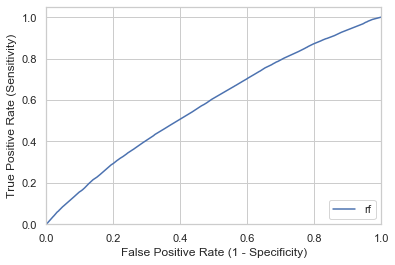

In [11]:
X_feat = pred

y = resp

X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)


t2 = RandomForestClassifier(n_estimators=100,max_depth=4,min_samples_leaf=20)

t2.fit(X_train,y_train)
y_test_pred = t2.predict_proba(X_test)[:,1]
new = np.concatenate((y_test.values.reshape(-1,1),y_test_pred.reshape(-1,1)),axis=1)

fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_test_pred)

sns.mpl.pyplot.plot(fpr_rf, tpr_rf,label="rf")
sns.mpl.pyplot.xlim([0, 1])
sns.mpl.pyplot.ylim([0, 1.05])
sns.mpl.pyplot.legend(loc="lower right")
sns.mpl.pyplot.xlabel('False Positive Rate (1 - Specificity)')
sns.mpl.pyplot.ylabel('True Positive Rate (Sensitivity)')

In [12]:

fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_test_pred)
print("RF model AUC: ",metrics.roc_auc_score(y_test, y_test_pred))



RF model AUC:  0.57890532173941


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

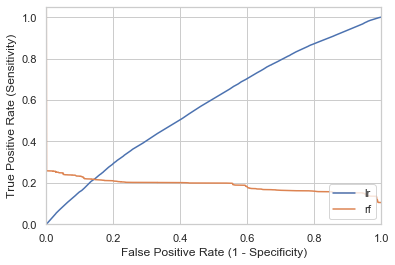

In [17]:

y_test_pred = t2.predict_proba(X_test)[:,1]
new = np.concatenate((y_test.values.reshape(-1,1),y_test_pred.reshape(-1,1)),axis=1)

fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_test_pred)
sns.mpl.pyplot.plot(fpr_rf, tpr_rf,label="lr")
sns.mpl.pyplot.plot(fpr_rf, thresholds_rf,label="rf")
sns.mpl.pyplot.xlim([0, 1])
sns.mpl.pyplot.ylim([0, 1.05])
sns.mpl.pyplot.legend(loc="lower right")
sns.mpl.pyplot.xlabel('False Positive Rate (1 - Specificity)')
sns.mpl.pyplot.ylabel('True Positive Rate (Sensitivity)')

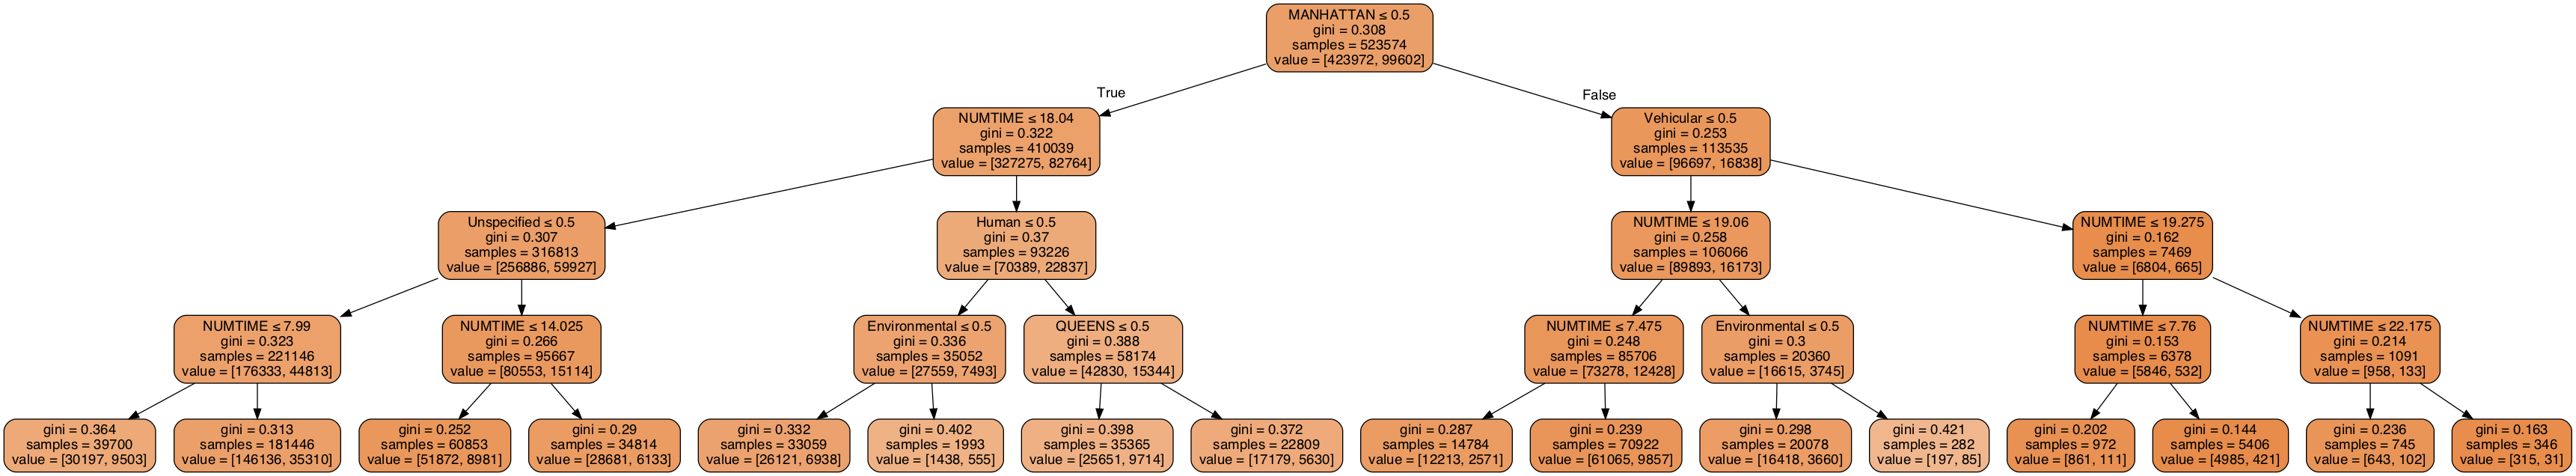

In [31]:
pred = list(zip(data['NUMTIME'],data['MANHATTAN'],data['QUEENS'],data['BRONX'],data['STATEN ISLAND'],data['BROOKLYN'],data['Human'],data['Environmental'],data['Vehicular'],data['Unspecified']))
X_feat=pred
y = resp

X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2)


t = DecisionTreeClassifier(max_depth=4,min_samples_leaf=20)

t.fit(X_train,y_train)

dot_data = StringIO()  
export_graphviz(t, out_file=dot_data,  
                    feature_names=['NUMTIME','MANHATTAN','QUEENS','BRONX','STATEN ISLAND','BROOKLYN','Human','Environmental','Vehicular','Unspecified'],
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [44]:
data1 = pd.read_csv("MVC.csv")
print(data.columns)

Index(['BOROUGH', 'NUMTIME', 'LONGITUDE', 'LATITUDE',
       'CONTRIBUTING FACTOR VEHICLE 1', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'PERSONS_AFFECTED',
       'PEDESTRIANS_AFFECTED', 'BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS',
       'STATEN ISLAND', 'PERSONS_TF', 'Environmental', 'Human', 'Unspecified',
       'Vehicular'],
      dtype='object')


In [45]:
data1['PERSONS_AFFECTED'] = data1['NUMBER OF PERSONS KILLED'] + data1['NUMBER OF PERSONS INJURED']
data1['PEDESTRIANS_AFFECTED'] = data1['NUMBER OF PEDESTRIANS KILLED'] + data1['NUMBER OF PEDESTRIANS INJURED']

In [ ]:
orough_dummy = data1.BOROUGH.str.get_dummies()
data = pd.concat([data1,borough_dummy],axis=1)

data1 = data1.dropna()
data1 = data1[data1.LONGITUDE !=0]

data1['PERSONS_TF']=0
data1.loc[data1['PERSONS_AFFECTED'] > 0, 'PERSONS_TF']= 1
data1.loc[data1['PERSONS_AFFECTED'] == 0, 'PERSONS_TF']= 0

In [ ]:
value_counts = data1["CONTRIBUTING FACTOR VEHICLE 1"].value_counts(ascending=True)
remove = value_counts[value_counts <= 20].index
data1 = data1[~data1['CONTRIBUTING FACTOR VEHICLE 1'].isin(remove)]

data1['CONTRIBUTING FACTOR VEHICLE 1'] = data1['CONTRIBUTING FACTOR VEHICLE 1'].replace(['Driver Inattention/Distraction','Following Too Closely','Failure to Yield Right-of-Way','Backing Unsafely','Passing Too Closely','Unsafe Lane Changing','Passing or Lane Usage Improper','Turning Improperly','Traffic Control Disregarded','Driver Inexperience','Reaction to Uninvolved Vehicle','Unsafe Speed','Fatigued/Drowsy','Alcohol Involvement','Lost Consciousness','Aggressive Driving/Road Rage','Fell Asleep','Illnes','Drugs (illegal)','Drugs (Illegal)','Texting','Outside Car Distraction','Passenger Distraction','Prescription Medication','Failure to Keep Right','Illness','Other Electronic Device','Cell Phone (hand-Held)','Cell Phone (hands-free)','Eating or Drinking','Pedestrian/Bicyclist/Other Pedestrian Error/Confusion','Physical Disability','Reaction to Other Uninvolved Vehicle','Using On Board Navigation Device','Tinted Windows','Vehicle Vandalism','Cell Phone (hand-held)'],'Human')
data1['CONTRIBUTING FACTOR VEHICLE 1'] = data1['CONTRIBUTING FACTOR VEHICLE 1'].replace(['Other Vehicular','Oversized Vehicle','Brakes Defective','Steering Failure','Tire Failure/Inadequate','Driverless/Runaway Vehicle','Accelerator Defective','Other Lighting Defects','Tow Hitch Defective','Headlights Defective','Windshield Inadequate'],'Vehicular')
data1['CONTRIBUTING FACTOR VEHICLE 1'] = data1['CONTRIBUTING FACTOR VEHICLE 1'].replace(['Pavement Slippery','View Obstructed/Limited','Glare','Obstruction/Debris','Pavement Defective','Animals Action','Lane Marking Improper/Inadequate','Traffic Control Device Improper/Non-Working','Shoulders Defective/Improper'],'Environmental')
data1['CONTRIBUTING FACTOR VEHICLE 1'] = data1['CONTRIBUTING FACTOR VEHICLE 1'].replace(['80'],'Unspecified')

In [ ]:
factor_dummy = data1['CONTRIBUTING FACTOR VEHICLE 1'].str.get_dummies()
data1 = pd.concat([data1,factor_dummy],axis=1)

In [ ]:
pred = list(zip(data1['NUMTIME'],data1['MANHATTAN'],data1['QUEENS'],data1['BRONX'],data1['STATEN ISLAND'],data1['BROOKLYN'],data1['Human'],data1['Environmental'],data1['Vehicular'],data1['Unspecified']))
resp = data1['PERSONS_TF']
sm = SMOTE(random_state=42)
x_res,y_res = sm.fit_resample(pred,resp)
print('Resampled dataset shape %s' % Counter(y_res))

In [43]:
df = data1[data1.PERSONS_TF != 0]

AttributeError: 'DataFrame' object has no attribute 'PERSONS_TF'

In [41]:
print(df.columns)

Index(['BOROUGH', 'NUMTIME', 'LONGITUDE', 'LATITUDE',
       'CONTRIBUTING FACTOR VEHICLE 1', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'PERSONS_AFFECTED',
       'PEDESTRIANS_AFFECTED', 'BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS',
       'STATEN ISLAND', 'PERSONS_TF', 'Environmental', 'Human', 'Unspecified',
       'Vehicular'],
      dtype='object')


In [40]:
pred = list(zip(df['NUMTIME'],data['MANHATTAN'],data['QUEENS'],data['BRONX'],data['STATEN ISLAND'],data['BROOKLYN'],data['Human'],data['Environmental'],data['Vehicular'],data['Unspecified']))
resp = df['NUMBER OF CYCLIST INJURED']

X_feat = pred
y = resp
X_feat_train,X_feat_test, y_feat_train,y_feat_test = train_test_split(X_feat,y,test_size=0.2)

dtc = RandomForestClassifier()
grid={'max_depth':[1,2,3,4,5,10,20,30],
        'criterion':['gini','entropy'],
        'min_samples_leaf':[10,20,30,50,60]}

gs = GridSearchCV(dtc,grid,cv=3,verbose=True,return_train_score=False,n_jobs=-1)
gs.fit(X_feat,y)

scores = pd.DataFrame(gs.cv_results_).filter(regex='param_+|mean_test_score'
                                            ).sort_values('mean_test_score',
                                                          ascending=False).reset_index().drop(['index'],axis=1)
scores.head(10)

KeyError: 'NUMBER OF CYCLIST INJURED'

In [ ]:
def motorist_to_bin(x):
    if x == 0:
        return 0
    else:
        return 1
CarData["MOTORIST_AFFECTED"] = CarData["NUMBER OF MOTORIST INJURED"]+CarData["NUMBER OF MOTORIST KILLED"]
CarData['MOTORIST_TF']= CarData["MOTORIST_AFFECTED"].apply(motorist_to_bin)
CarData